In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/sa_2021_access.csv")
IND_u= pd.read_csv('../Datasets/sa_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    7237
1     772
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,1.0,2,4
1,1,3.0,1,5
2,1,2.0,1,1
3,1,3.0,1,4
4,2,2.0,3,1
...,...,...,...,...
8004,1,3.0,2,5
8005,1,2.0,2,4
8006,2,3.0,2,5
8007,2,2.0,2,3


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,900,840,886,791,611
2,434,506,604,799,1097
3,38,42,60,108,293


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,-0.832277,0.328192,-0.112133,-0.235397,0.072925,0.228228,-0.268386,-0.125738,-0.027715
1,-0.832277,0.328192,-0.112133,-0.235397,0.072925,0.228228,-0.268386,-0.125738,-0.027715
2,-0.832277,0.328192,-0.112133,-0.235397,0.072925,0.228228,-0.268386,-0.125738,-0.027715
3,-1.158509,-0.294342,0.216272,0.406395,0.095155,-0.242153,0.163759,-0.079731,-0.011929
4,0.432734,0.045795,-0.104679,-0.322304,0.098191,-0.507923,-0.159029,0.462248,-0.039214
...,...,...,...,...,...,...,...,...,...
8004,0.424063,0.095839,-0.613726,0.092603,-0.046660,-0.060611,0.186936,0.316232,-0.036029
8005,0.738572,0.123053,-0.489992,0.198736,0.128235,-0.150618,0.170210,-0.310297,0.002257
8006,0.787561,0.776060,0.763046,0.439840,1.491939,0.610816,0.371099,0.079808,0.444296
8007,0.738572,0.123053,-0.489992,0.198736,0.128235,-0.150618,0.170210,-0.310297,0.002257


In [9]:
mca_u = prince.MCA(n_components=28)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28
0,-0.559799,0.323564,-0.289462,0.116427,0.091041,0.020339,0.027676,-0.000241,-0.043483,-0.008237,...,0.031725,-0.009526,0.018722,0.013016,0.009121,-0.015018,-0.019841,0.005399,-0.007615,0.011499
1,-0.493599,0.340062,0.080160,-0.405816,0.127712,-0.001939,-0.079645,0.108200,0.090172,0.038800,...,0.010851,0.049688,-0.051377,0.011486,0.003104,0.085536,0.012887,0.019019,0.001216,0.029205
2,-0.493599,0.340062,0.080160,-0.405816,0.127712,-0.001939,-0.079645,0.108200,0.090172,0.038800,...,0.010851,0.049688,-0.051377,0.011486,0.003104,0.085536,0.012887,0.019019,0.001216,0.029205
3,-0.511990,0.322926,-0.106236,-0.137900,0.113077,0.007029,-0.028531,0.078377,0.026829,0.015422,...,0.024082,0.021115,-0.012726,0.022924,0.027729,0.013771,0.002951,0.011165,0.003323,0.003383
4,-0.047076,-0.294226,-0.029789,-0.357342,-0.088625,0.081377,-0.263462,0.064510,-0.025913,-0.136944,...,-0.237670,0.082375,-0.197465,0.126855,-0.420331,0.106722,0.216737,-0.014053,0.050788,-0.083041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8004,0.256925,-0.368446,-0.013692,0.513539,0.321944,-0.577414,-0.027541,0.136497,0.101625,0.111085,...,-0.367899,-0.053124,-0.102082,-0.060166,0.007512,-0.094939,0.051689,0.021382,-0.264375,0.213850
8005,0.149756,-0.254646,0.046462,0.104912,-0.439781,-0.341750,-0.175704,0.092436,0.096691,0.183438,...,0.048011,-0.068070,-0.047699,0.042964,-0.076243,0.070137,-0.074130,-0.027928,0.109444,0.012422
8006,0.268880,-0.101708,0.343932,-0.008931,-0.243148,0.100679,-0.347578,-0.121552,-0.034897,-0.183286,...,-0.408326,-0.137359,0.033828,0.502023,0.357610,0.072463,0.468359,-0.014722,0.207446,0.305159
8007,0.341879,-0.187472,-0.043804,0.191250,-0.492978,-0.175593,-0.070687,-0.239010,-0.187525,0.055150,...,-0.015013,-0.142233,-0.123553,-0.001291,0.050717,0.323437,0.085502,0.217348,0.032047,0.185724


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,female,age,educ,inc_q
0,-0.832277,0.328192,-0.112133,-0.235397,0.072925,0.228228,-0.268386,-0.125738,-0.027715,-0.559799,...,0.009121,-0.015018,-0.019841,0.005399,-0.007615,0.011499,1,1.0,2,4
1,-0.832277,0.328192,-0.112133,-0.235397,0.072925,0.228228,-0.268386,-0.125738,-0.027715,-0.493599,...,0.003104,0.085536,0.012887,0.019019,0.001216,0.029205,1,3.0,1,5
2,-0.832277,0.328192,-0.112133,-0.235397,0.072925,0.228228,-0.268386,-0.125738,-0.027715,-0.493599,...,0.003104,0.085536,0.012887,0.019019,0.001216,0.029205,1,2.0,1,1
3,-1.158509,-0.294342,0.216272,0.406395,0.095155,-0.242153,0.163759,-0.079731,-0.011929,-0.511990,...,0.027729,0.013771,0.002951,0.011165,0.003323,0.003383,1,3.0,1,4
4,0.432734,0.045795,-0.104679,-0.322304,0.098191,-0.507923,-0.159029,0.462248,-0.039214,-0.047076,...,-0.420331,0.106722,0.216737,-0.014053,0.050788,-0.083041,2,2.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8004,0.424063,0.095839,-0.613726,0.092603,-0.046660,-0.060611,0.186936,0.316232,-0.036029,0.256925,...,0.007512,-0.094939,0.051689,0.021382,-0.264375,0.213850,1,3.0,2,5
8005,0.738572,0.123053,-0.489992,0.198736,0.128235,-0.150618,0.170210,-0.310297,0.002257,0.149756,...,-0.076243,0.070137,-0.074130,-0.027928,0.109444,0.012422,1,2.0,2,4
8006,0.787561,0.776060,0.763046,0.439840,1.491939,0.610816,0.371099,0.079808,0.444296,0.268880,...,0.357610,0.072463,0.468359,-0.014722,0.207446,0.305159,2,3.0,2,5
8007,0.738572,0.123053,-0.489992,0.198736,0.128235,-0.150618,0.170210,-0.310297,0.002257,0.341879,...,0.050717,0.323437,0.085502,0.217348,0.032047,0.185724,2,2.0,2,3


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .89, 1:1}], 
              'C': [100]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 100, 'class_weight': {0: 0.89, 1: 1}}
Best score: 0.8315331159095397


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_)
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9888301513099451
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1461
           1       0.75      0.91      0.82       141

    accuracy                           0.97      1602
   macro avg       0.87      0.94      0.90      1602
weighted avg       0.97      0.97      0.97      1602



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [15]:
acc= accuracy_score(y_test, y_pred)
pre= precision_score(y_test, y_pred)
rec= recall_score(y_test, y_pred)
f_1= f1_score(y_test, y_pred)
acc, rec, pre, f_1, auc1

(0.9650436953807741,
 0.9078014184397163,
 0.7485380116959064,
 0.8205128205128205,
 0.9888301513099451)

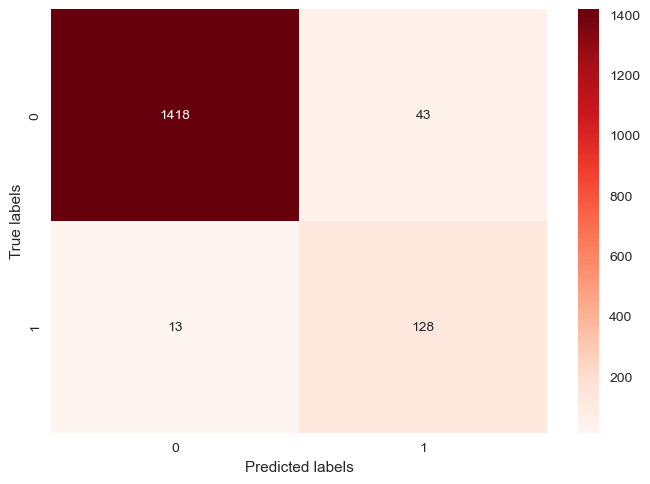

In [16]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [17]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

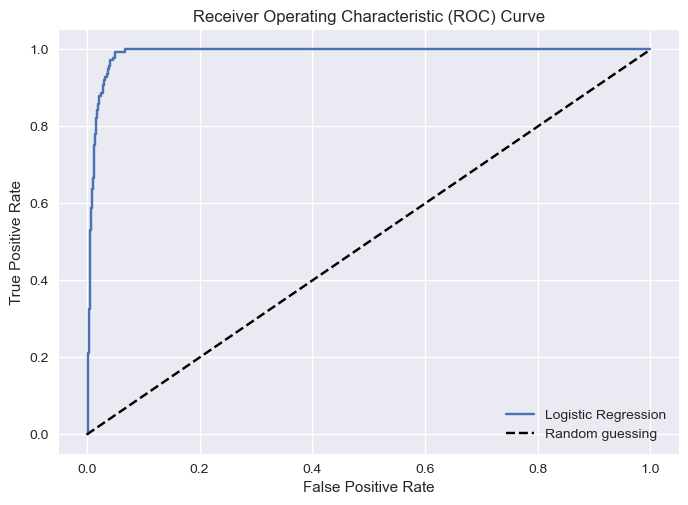

In [18]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [19]:
weights= [i for i in np.linspace(0, 1,100)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(76, 77)],
    'max_depth': [i for i in range(12, 13)],
    'min_samples_split': [i for i in range(2,3)],
    'min_samples_leaf': [i for i in range(8,9)],
    'max_features': ['sqrt'],
    'class_weight': [{0: .25 , 1: .81} ]
}
rf = RandomForestClassifier(random_state= 42)

In [20]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.25, 1: 0.81}, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 76}
Best score: 0.7580286679456296


In [21]:
auc2 = roc_auc_score(y_test, proba[:,1])
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9756408949471119
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1461
           1       0.70      0.71      0.70       141

    accuracy                           0.95      1602
   macro avg       0.84      0.84      0.84      1602
weighted avg       0.95      0.95      0.95      1602



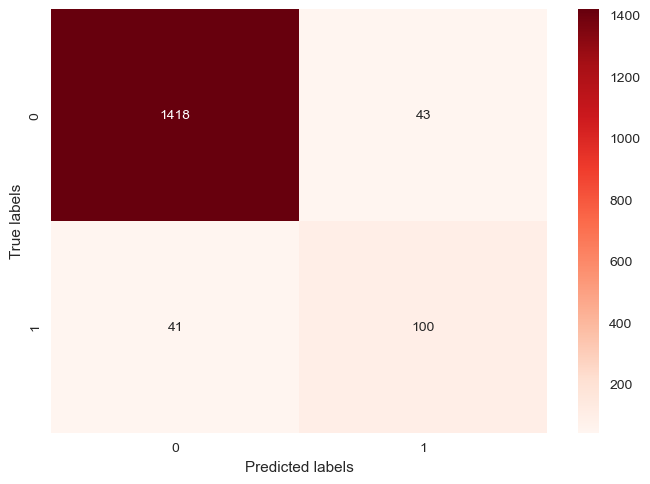

In [22]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [23]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

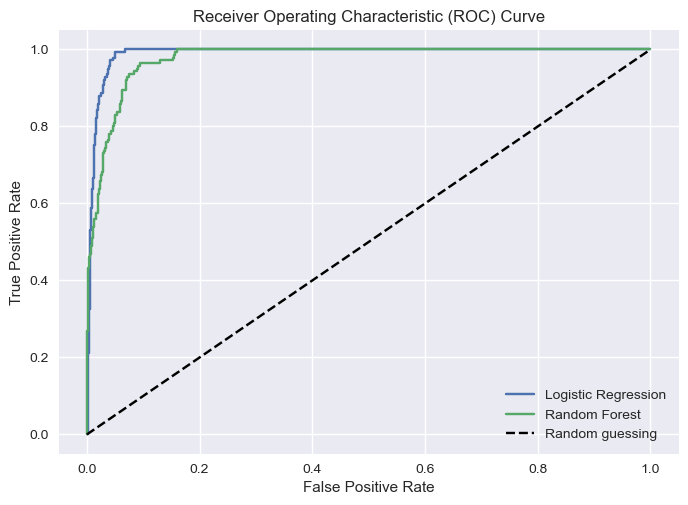

In [24]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [25]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [26]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.812987273191618


In [27]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [28]:
auc3 = roc_auc_score(y_test, y_)
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9831845476478269
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1461
           1       0.74      0.74      0.74       141

    accuracy                           0.95      1602
   macro avg       0.86      0.86      0.86      1602
weighted avg       0.95      0.95      0.95      1602



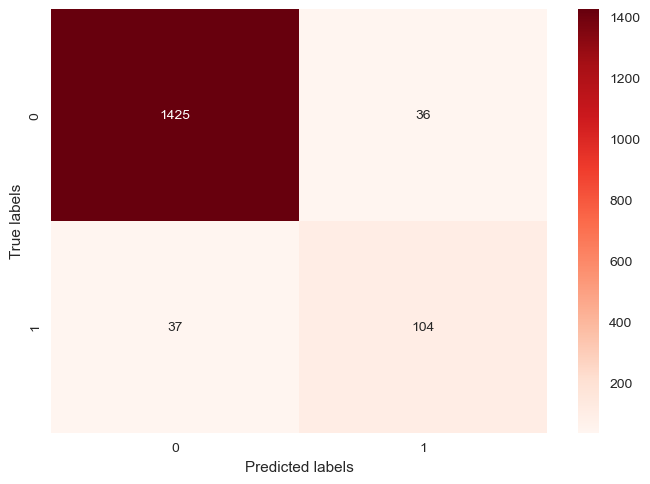

In [29]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [30]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

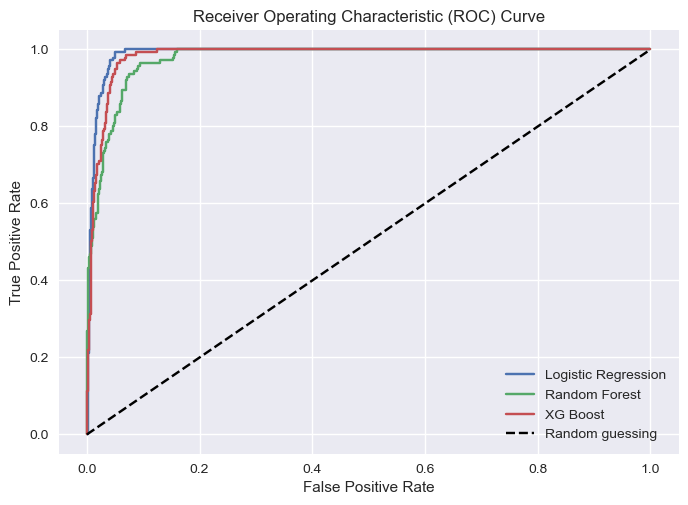

In [31]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [32]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [34]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
161/161 [==============================] - 0s 928us/step - loss: 0.2518 - precision: 0.8261 - recall: 0.0747 - val_loss: 0.1587 - val_precision: 0.8228 - val_recall: 0.5328
Epoch 2/50
161/161 [==============================] - 0s 484us/step - loss: 0.1246 - precision: 0.7833 - recall: 0.6248 - val_loss: 0.1028 - val_precision: 0.7905 - val_recall: 0.6803
Epoch 3/50
161/161 [==============================] - 0s 481us/step - loss: 0.0948 - precision: 0.7850 - recall: 0.8035 - val_loss: 0.0943 - val_precision: 0.7966 - val_recall: 0.7705
Epoch 4/50
161/161 [==============================] - 0s 485us/step - loss: 0.0849 - precision: 0.7967 - recall: 0.8468 - val_loss: 0.0916 - val_precision: 0.7444 - val_recall: 0.8115
Epoch 5/50
161/161 [==============================] - 0s 500us/step - loss: 0.0808 - precision: 0.8075 - recall: 0.8487 - val_loss: 0.0947 - val_precision: 0.7152 - val_recall: 0.9262
Epoch 6/50
161/161 [==============================] - 0s 486us/step - loss: 0.07

161/161 [==============================] - 0s 503us/step - loss: 0.0133 - precision: 0.9747 - recall: 0.9823 - val_loss: 0.1592 - val_precision: 0.8115 - val_recall: 0.8115
Epoch 46/50
161/161 [==============================] - 0s 478us/step - loss: 0.0120 - precision: 0.9712 - recall: 0.9921 - val_loss: 0.1648 - val_precision: 0.8033 - val_recall: 0.8033
Epoch 47/50
161/161 [==============================] - 0s 475us/step - loss: 0.0117 - precision: 0.9749 - recall: 0.9902 - val_loss: 0.1868 - val_precision: 0.8073 - val_recall: 0.7213
Epoch 48/50
161/161 [==============================] - 0s 471us/step - loss: 0.0109 - precision: 0.9787 - recall: 0.9921 - val_loss: 0.1795 - val_precision: 0.7687 - val_recall: 0.8443
Epoch 49/50
161/161 [==============================] - 0s 469us/step - loss: 0.0099 - precision: 0.9768 - recall: 0.9921 - val_loss: 0.1740 - val_precision: 0.7852 - val_recall: 0.8689
Epoch 50/50
161/161 [==============================] - 0s 474us/step - loss: 0.0104 - p

In [35]:
y_ = ann.predict(X_test)

51/51 [==============================] - 0s 254us/step


In [36]:
y_= y_.reshape(y_.shape[0],)

In [37]:
y_pred= np.array([round(i) for i in y_])

In [38]:
auc4 = roc_auc_score(y_test, y_)
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9838690103446099
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1461
           1       0.75      0.81      0.78       141

    accuracy                           0.96      1602
   macro avg       0.86      0.89      0.88      1602
weighted avg       0.96      0.96      0.96      1602



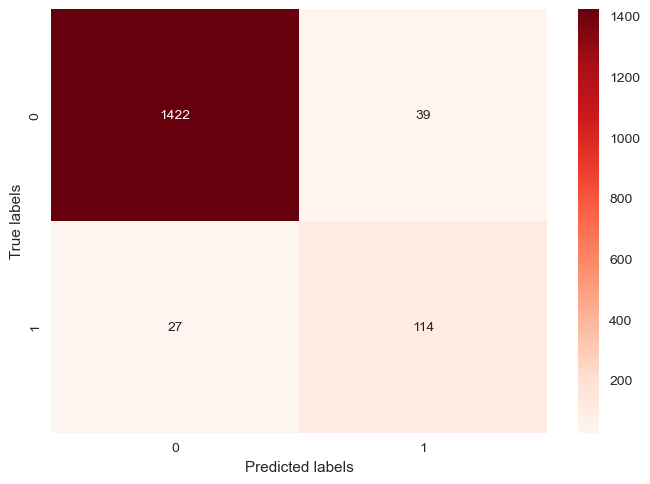

In [39]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [40]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

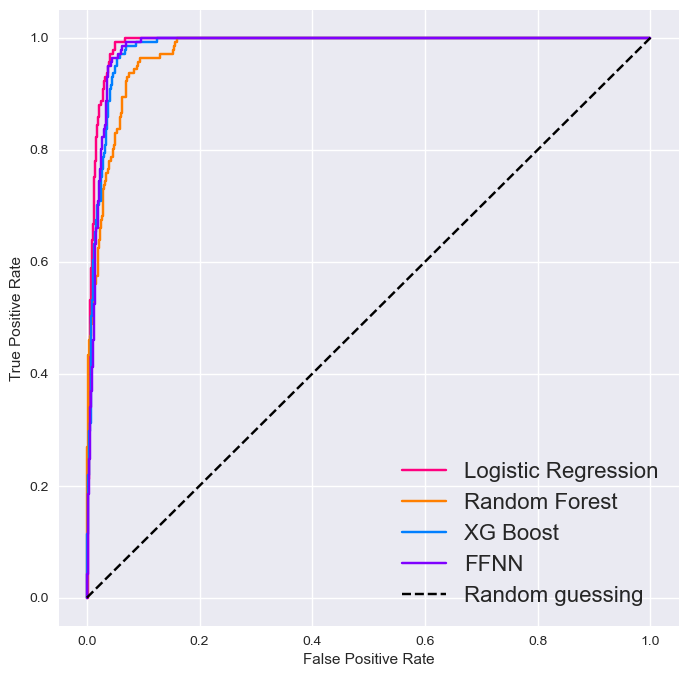

In [41]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_ken.png")
plt.show()

## Model Evaluations

In [42]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9650 & 0.9476 & 0.9544 & 0.9588 \\
   Recall & 0.9078 & 0.7092 & 0.7376 & 0.8085 \\
Precision & 0.7485 & 0.6993 & 0.7429 & 0.7451 \\
 F1-Score & 0.8205 & 0.7042 & 0.7402 & 0.7755 \\
      AUC & 0.9888 & 0.9756 & 0.9832 & 0.9839 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [43]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [44]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [45]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-2.359774080358722, 4.118885521834167, -0.08392201760295953)

In [46]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [47]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.3512844017897522)

In [48]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.9911209843497167, 1.5052353730868862, -0.023641371400086316)

In [49]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [50]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [51]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [52]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

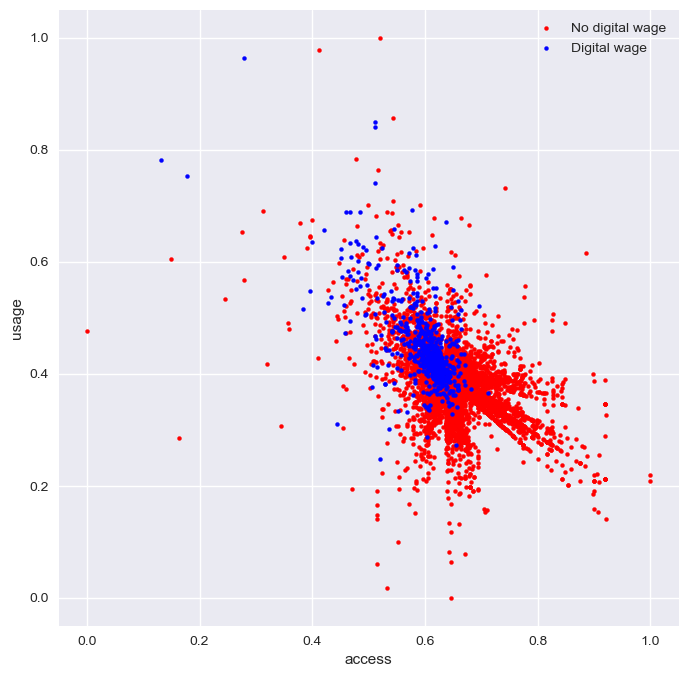

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_ken')
plt.show()

In [54]:
IND_fin['access'].describe()

count    8009.000000
mean        0.648716
std         0.059019
min         0.000000
25%         0.622315
50%         0.644089
75%         0.671306
max         1.000000
Name: access, dtype: float64

In [55]:
IND_fin['usage'].describe()

count    8009.000000
mean        0.387557
std         0.062505
min         0.000000
25%         0.358070
50%         0.385452
75%         0.411185
max         1.000000
Name: usage, dtype: float64

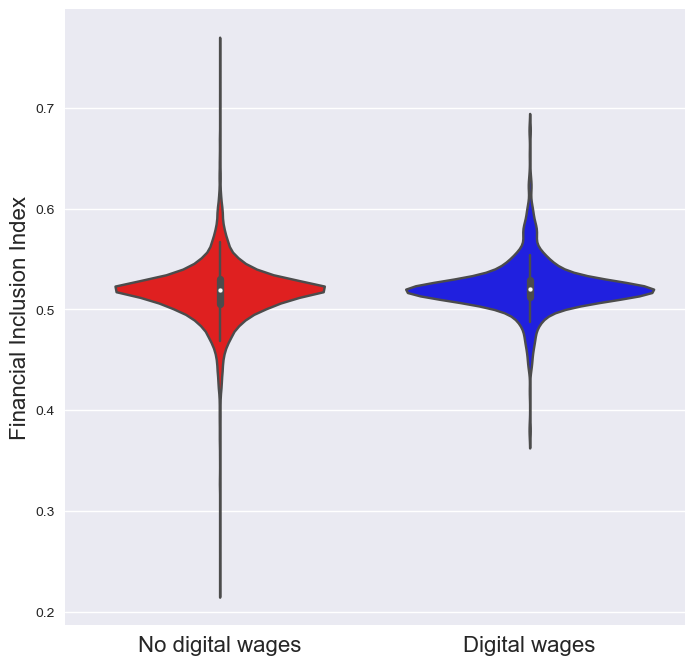

In [56]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_ken')

# Show the plot
plt.show()

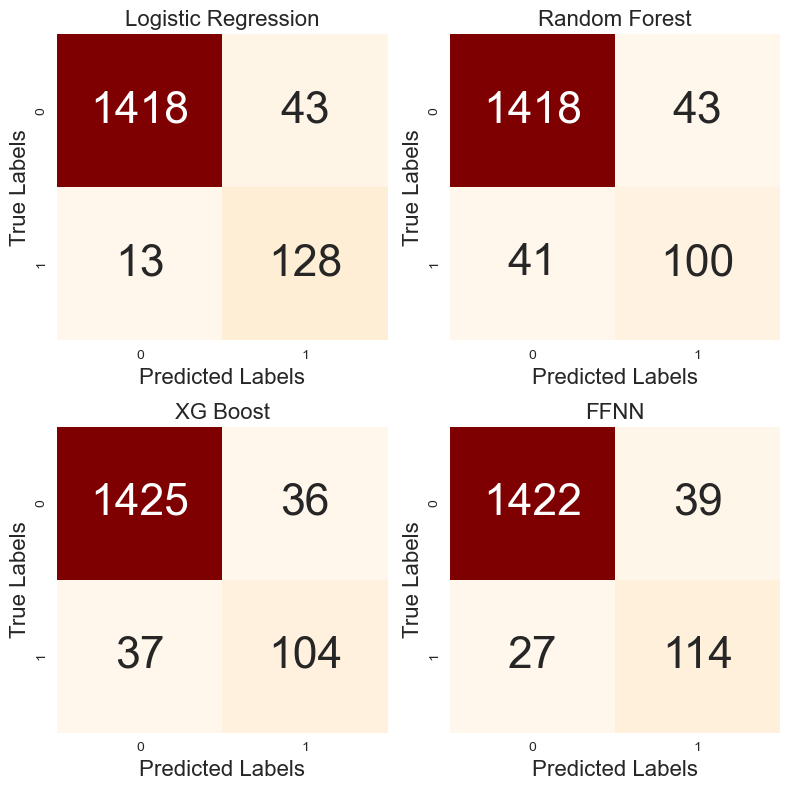

[CV] END ................C=100, class_weight={0: 0.89, 1: 1}; total time=   0.1s
[CV] END ................C=100, class_weight={0: 0.89, 1: 1}; total time=   0.1s
[CV] END class_weight={0: 0.25, 1: 0.81}, max_depth=12, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=76; total time=   0.7s
[CV] END class_weight={0: 0.25, 1: 0.81}, max_depth=12, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=76; total time=   0.5s
[CV] END class_weight={0: 0.25, 1: 0.81}, max_depth=12, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=76; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=376, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.6s
[CV] END ................C=100, class_weight={0: 0.89, 1: 1}; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=376, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.7s
[CV] EN

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="OrRd", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_sa.png')
# Display the plot
plt.show()

## Feature Importance

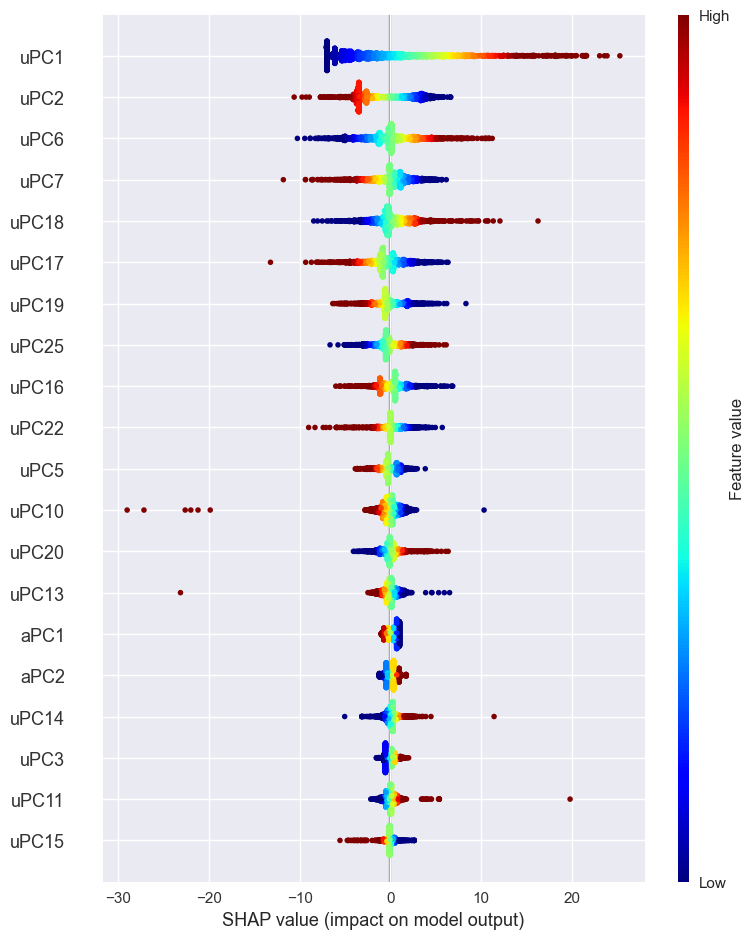

In [80]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [81]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

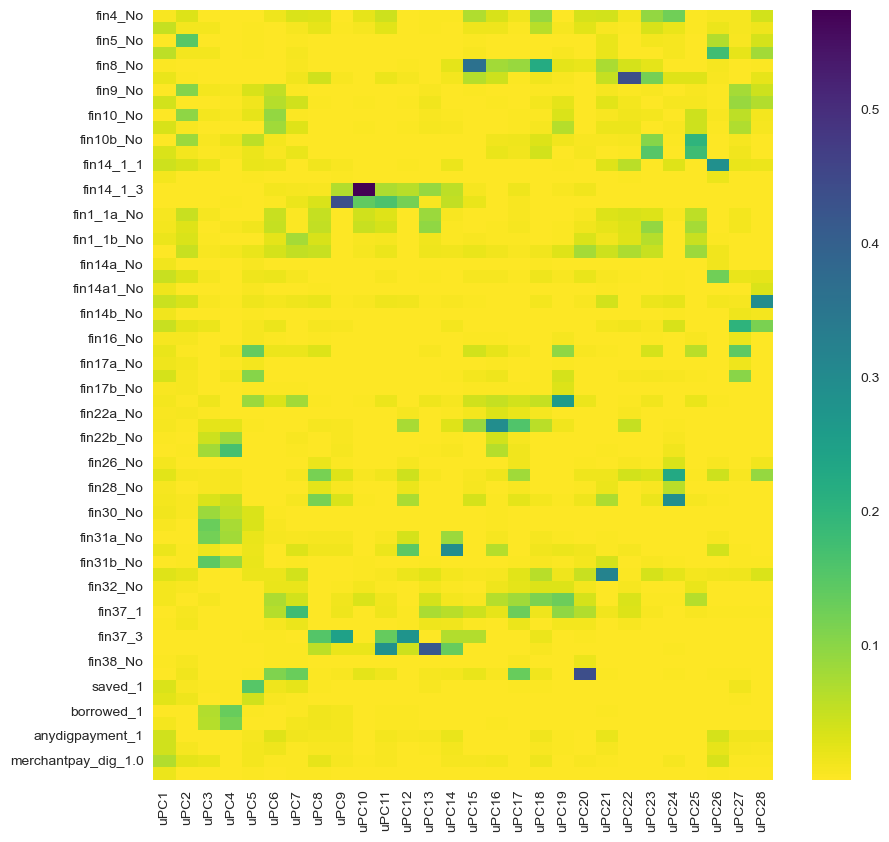

In [82]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_ken.png')
plt.show()

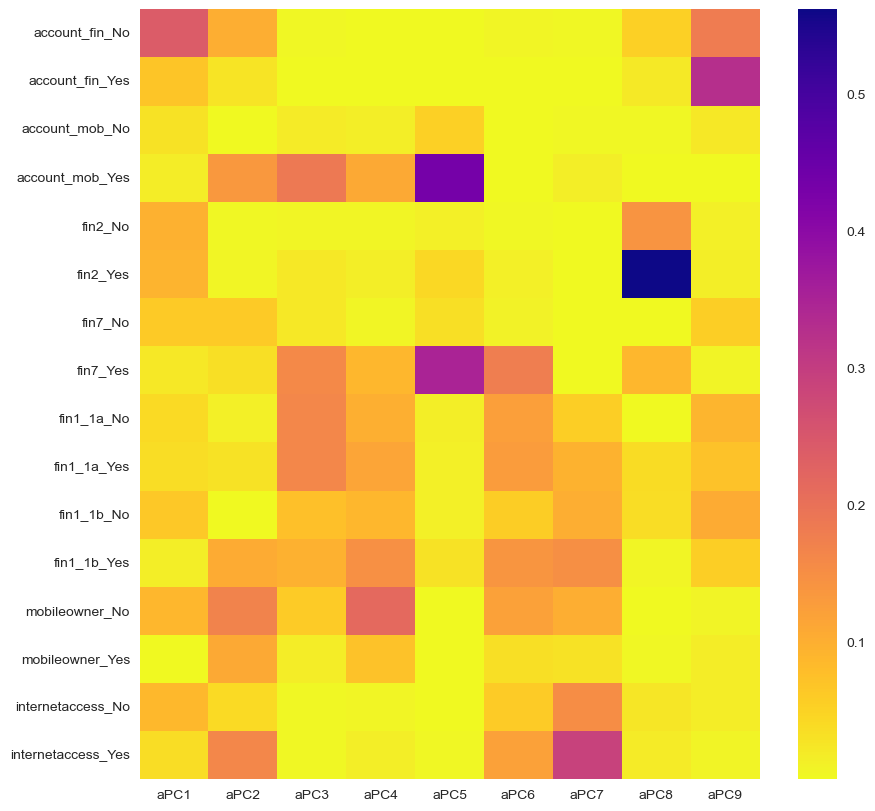

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_ken.png')
plt.show()

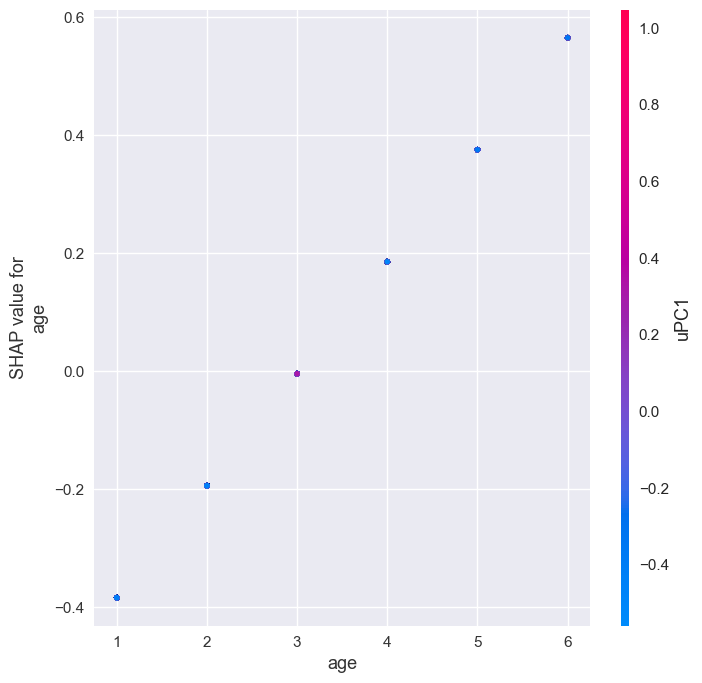

In [84]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

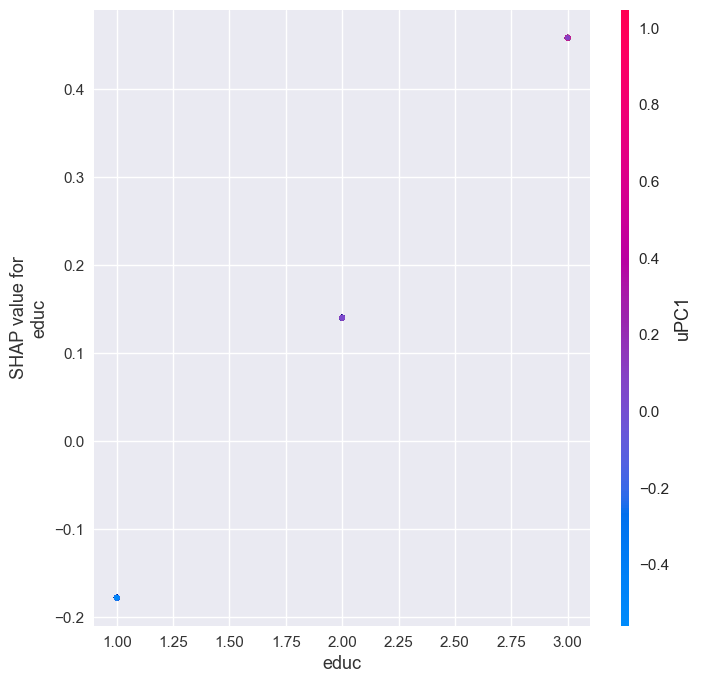

In [85]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

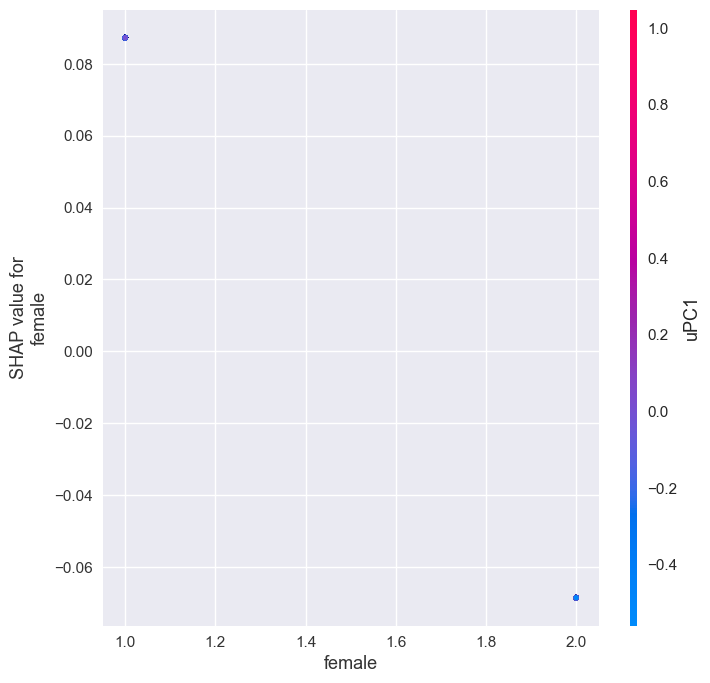

In [86]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

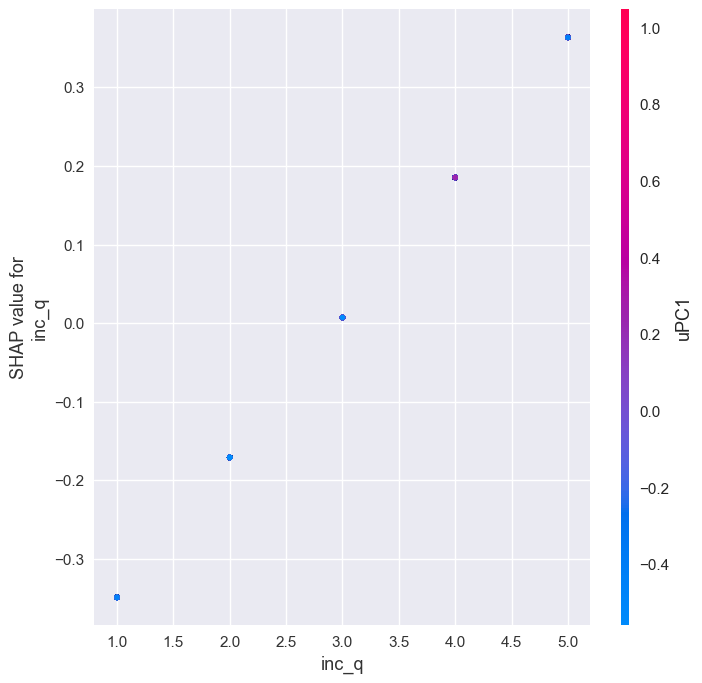

In [87]:
ig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()